<font color = 'blue'>
    
# Lead_Score_Case_Study:
</font>   

<font color = 'blue'>

**1.Data understanding and EDA**  
  
**2.Data Preparation**  

**3.Standard Scaling on Train set**     

**4.Feature selection using RFE method**    

**5.Modeling**  

**6.Prediction on train set**  

**7.Ploting ROC curve**  

**8.Finding probability cut off**  

**9.Precision and recall tradeoff**  

**10.Prediction on test set**  

**11.Summary**  
</font>

In [1]:
# import Libraries 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import classification_report, confusion_matrix
import itertools

<font color='blue'>
    
## Data understanding and EDA  
</font>

In [2]:
# import data set and check top 5 rows
df_leads = pd.read_csv('Leads.csv')
df_leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
# check the shape of the dataframe
df_leads.shape

(9240, 37)

In [4]:
# Lead conversion rate with the original data set
(df_leads['Converted'].sum()/len(df_leads.index)*100).round(2)

38.54

<font color = 'blue'>

## Lead conversion rate with the original data set is about <font color = 'red'>38.5%</font>. Business goal is to reach <font color = 'red'>80%</font> lead conversion rate.

</font>

In [5]:
# check the data info
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

<font color='red'>
    
**It is mentioned in the problem statement, that many of the categorical variables have a level called ‘Select’, which need to be handled as it is as good as null value.**  
  
**There is a possibility to have ‘Select’ if there is no option selected by lead/customer.** 
</font>

In [6]:
# check what are the variables having 'Select'
df_leads.columns[df_leads.apply(lambda row: row.astype(str).str.contains('Select').any(), axis=0).values]

Index(['Specialization', 'How did you hear about X Education', 'Lead Profile',
       'City'],
      dtype='object')

<font color='red'>

**There are four categorical variables having ‘Select’ as one of the levels.**

</font>

In [7]:
# replace 'Select' with NaN values, As it is considered that no value entered. So replace with null
df_leads.replace('Select',np.nan, inplace = True)

In [8]:
# check missing / null values
df_leads_missing_values_perc = round(df_leads.isnull().sum()/len(df_leads.index)*100,2).sort_values(ascending = False)
df_leads_missing_values_perc = df_leads_missing_values_perc.reset_index()
df_leads_missing_values_perc.columns = ['Features','Total_missing_values']
df_leads_missing_values_perc

,Features,Total_missing_values
0,How did you hear about X Education,78.46
1,Lead Profile,74.19
2,Lead Quality,51.59
3,Asymmetrique Profile Score,45.65
4,Asymmetrique Activity Score,45.65
5,Asymmetrique Profile Index,45.65
6,Asymmetrique Activity Index,45.65
7,City,39.71
8,Specialization,36.58
9,Tags,36.29


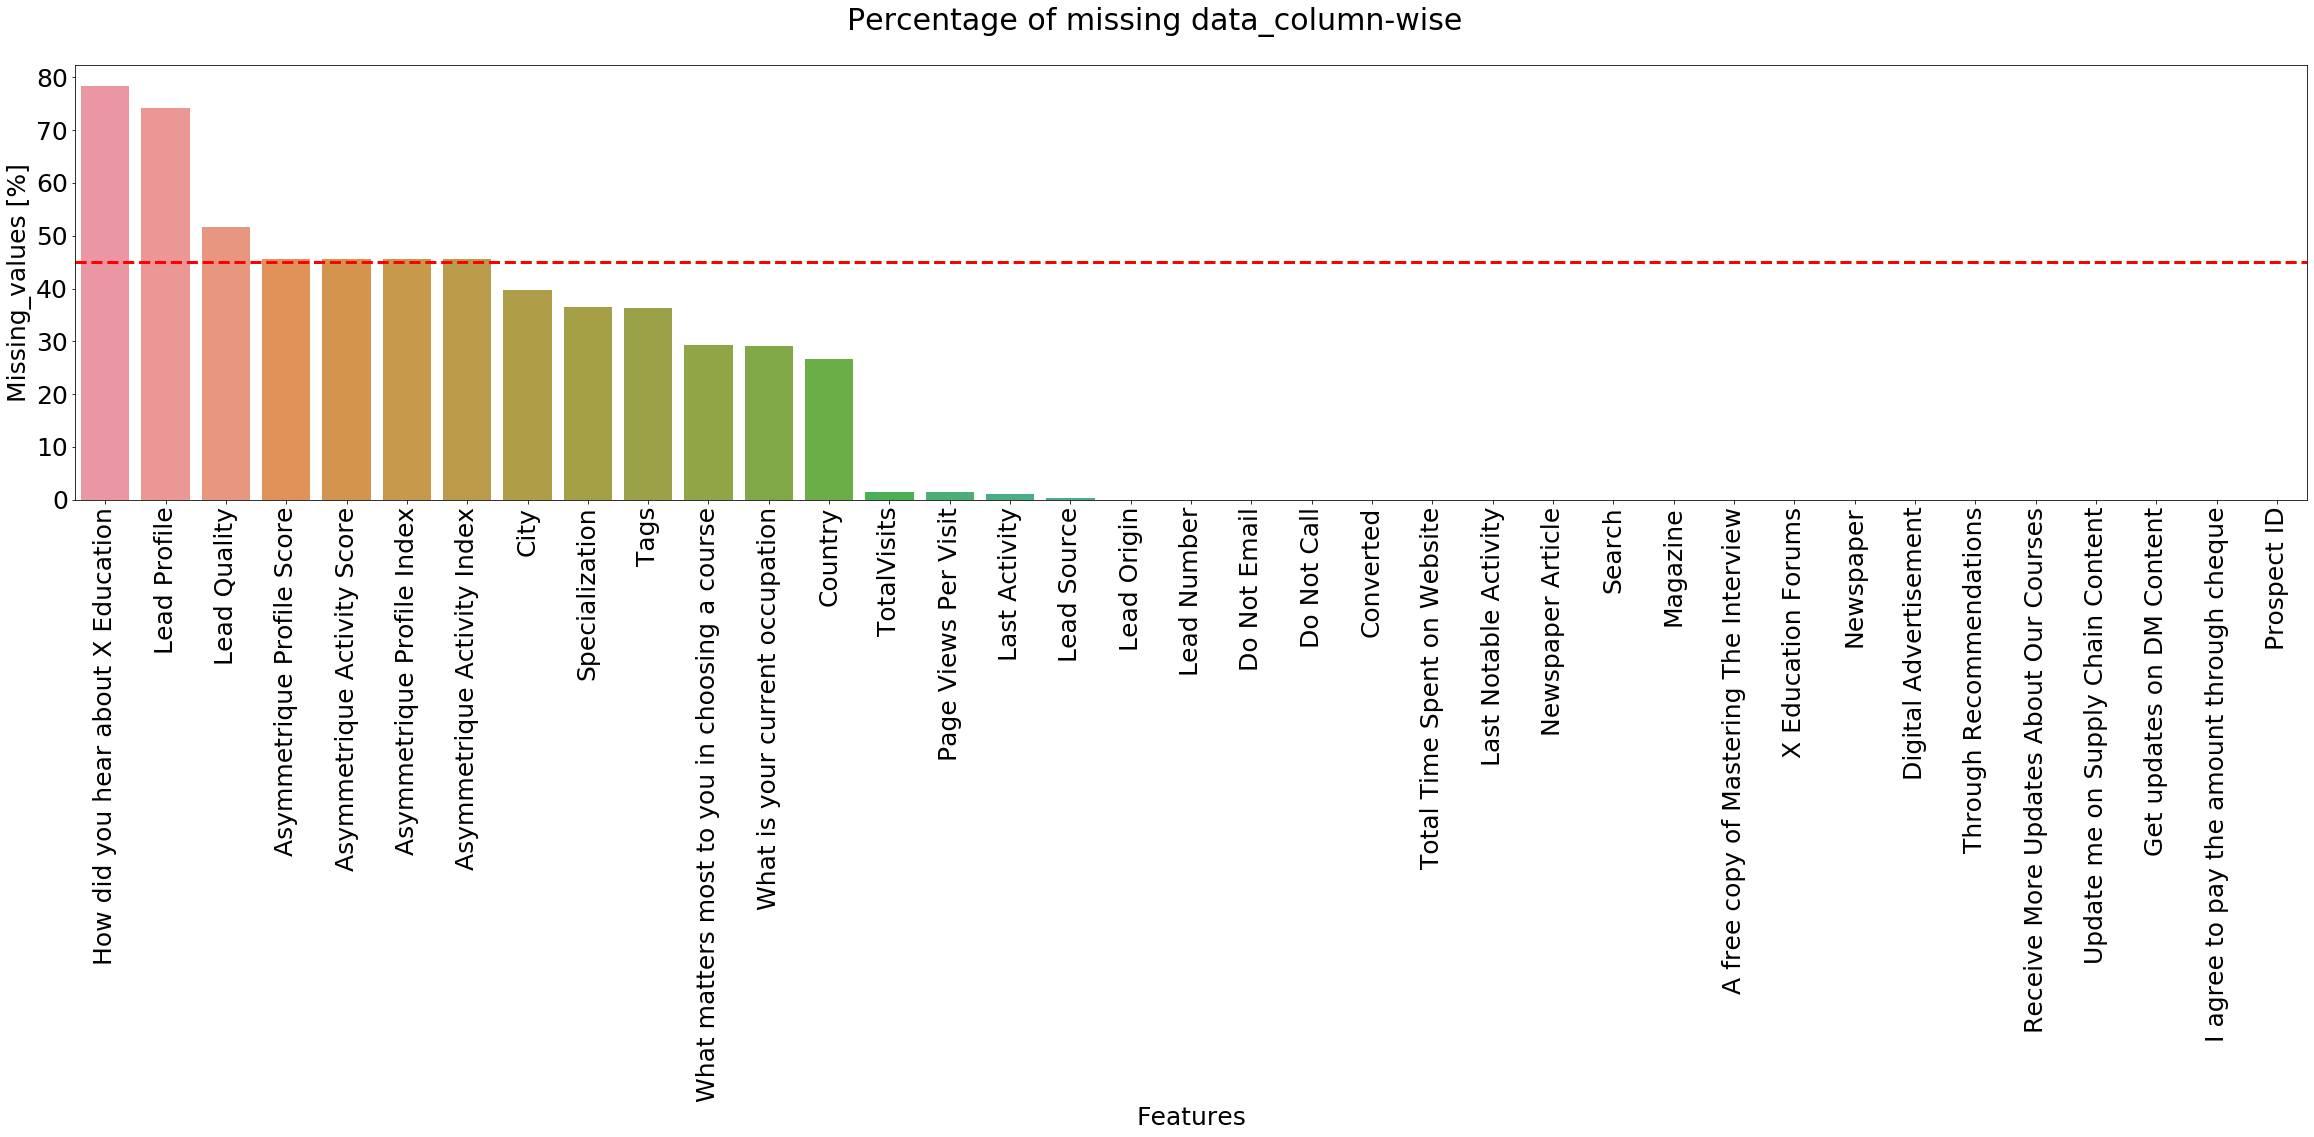

In [9]:
# plot the original data set missing values percentage and plot horizontal line with 45% missing value percentage
plt.figure(figsize = (40,8))
fig = sns.barplot(x = 'Features', y = 'Total_missing_values', data = df_leads_missing_values_perc)
plt.axhline(y = 45, color = 'r', linestyle = '--',linewidth = 3.0)
plt.xticks(rotation=90)
plt.suptitle('Percentage of missing data_column-wise', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Missing_values [%]',fontsize = 25)
plt.xlabel('Features',fontsize = 25)
plt.show()

In [10]:
# List of columns having missing values more than 45% 
col_list_missing_values = df_leads_missing_values_perc.loc[(df_leads_missing_values_perc['Total_missing_values']>= 45.0)]
col_list_missing_values = col_list_missing_values['Features'].values.tolist()

print('\033[1m'+'\x1b[31m'+'Columns with high percentage of missing values[>45%]: \n'+'\033[0m')
for i in col_list_missing_values:
    print('\t'+'\033[94m'+ i)

Columns with high percentage of missing values[>45%]: 

	How did you hear about X Education
	Lead Profile
	Lead Quality
	Asymmetrique Profile Score
	Asymmetrique Activity Score
	Asymmetrique Profile Index
	Asymmetrique Activity Index


In [11]:
# drop the columns having missing values more than 45%
df_leads.drop(columns = col_list_missing_values, inplace = True)

In [12]:
# Check the categorical column's describe details. 
df_leads.select_dtypes(include='object').describe()

,Prospect ID,Lead Origin,Lead Source,Do Not Email,Do Not Call,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,...,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
count,9240,9240,9204,9240,9240,9137,6779,5860,6550,6531,...,9240,9240,9240,5887,9240,9240,5571,9240,9240,9240
unique,9240,5,21,2,2,17,38,18,6,3,...,2,2,1,26,1,1,6,1,2,16
top,6fc0b277-e8cc-4f23-a50a-127fded059a8,Landing Page Submission,Google,No,No,Email Opened,India,Finance Management,Unemployed,Better Career Prospects,...,No,No,No,Will revert after reading the email,No,No,Mumbai,No,No,Modified
freq,1,4886,2868,8506,9238,3437,6492,976,5600,6528,...,9236,9233,9240,2072,9240,9240,3222,9240,6352,3407


<font color='red'>

**Note: Check the columns like ‘Do Not Email’, where ‘NO’ items frequency is more than 8500 out of 9240 rows. Such columns are not useful for predictions.  
also There are some columns having only 1 unique value, in this case top frequency for those columns will be ~9240. So those columns are not useful for modeling. We can drop them, Of course,those columns also comes under high-frequency items check.**

</font>

In [13]:
# Check the categorical column's top items frequency. 
# If the frequency of the top item is more than 8000 out of 9240 rows, 
# then those columns are not must informative to consider for modeling.

df_cat_freq = df_leads.select_dtypes(include='object').describe()[-1:]
list_cat_freq_drop_col = df_cat_freq.loc[:, (df_cat_freq > 8000).any(axis=0)].columns.tolist()

print('\033[1m'+'\x1b[31m'+'Category columns with more than 8000 top frequency unique item: \n'+'\033[0m')
for i in list_cat_freq_drop_col:
    print('\t'+'\033[94m'+ i)

Category columns with more than 8000 top frequency unique item: 

	Do Not Email
	Do Not Call
	Search
	Magazine
	Newspaper Article
	X Education Forums
	Newspaper
	Digital Advertisement
	Through Recommendations
	Receive More Updates About Our Courses
	Update me on Supply Chain Content
	Get updates on DM Content
	I agree to pay the amount through cheque


In [14]:
# drop the columns listed ‘list_cat_freq_drop_col’
df_leads.drop(columns = list_cat_freq_drop_col, inplace = True)
df_leads.shape

(9240, 17)

In [15]:
# check the missing values
round(df_leads.isnull().sum()/len(df_leads.index)*100,2).sort_values(ascending = False)

City                                             39.71
Specialization                                   36.58
Tags                                             36.29
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Lead Number                                       0.00
Lead Origin                                       0.00
Last Notable Activity                             0.00
Converted                                         0.00
Total Time Spent on Website                       0.00
A free copy of Mastering The Interview            0.00
Prospect ID                                       0.00
dtype: float64

<font color='red'>

**Let’s Analyse missing values less than 40% columns, In the following cells defined some functions which will be useful to plot categorical variables with it’s distribution percentage w.r.t Target variable.**
</font>

In [16]:
# function to create annotation on the each bar in the bar plot
def Perc_annotation(fig,font_size,En_perc):
    for p in fig.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if En_perc == 1:
            fig.annotate('{:.0f}%'.format(height), (x+0.00, y + height + .5),fontsize=font_size)
        else:
            fig.annotate('{:.0f}'.format(height), (x+0.00, y + height + .5),fontsize=font_size)

In [17]:
# transform the categorical values to percentages
def transform_df_with_perc_calc_barplot(df,column_name,hue,En_OrderCat):
    
    # goupby with hue and column name and extract only 'Lead Number'
    data_temp = df.groupby([hue,column_name]).count()[['Lead Number']] 
    #reset the index
    data_temp.reset_index(inplace = True)
    # list the unique items from the specified column name
    list_items = list(data_temp[column_name].unique())
    df_perc =pd.DataFrame
    count = 0
    for i in list_items: # for each column item
        loc_df = data_temp.loc[data_temp[column_name]==i] # slice the data_temp w.r.t each column item
        if En_OrderCat==1:
            hue_u_len = len(df[hue].unique())
            loc_df = loc_df.groupby([column_name,hue]).sum()[(count*hue_u_len):hue_u_len+(count*hue_u_len)] 
        else:
            loc_df = loc_df.groupby([column_name,hue]).sum() # group by with coumn_name & hue with sum
        
        loc_df = loc_df.apply(lambda row:round(row/loc_df.values.sum()*100,1)) # create percentage contribution of hue.
        if count == 0:
            df_perc = loc_df.copy() # initialise the data_perc when first loop active
        else:
            df_perc = df_perc.append(loc_df) # append the result dataframe with df_perc 
        count+=1
    df_perc.columns = ['Percentage'] # rename the columns with 'Percentage'
    df_perc.reset_index(inplace = True) # reset the index,to make avail column_name & hue in the data_perc columns list
    return(df_perc)

In [18]:
# single barplot with hue,categories will plot with percentages along with annotations 
def barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot):
    
# Percentage contribution of NAME_CONTRACT_TYPE with respect to TARGET
# use the defined fucn for transforming data in to percentage 
# ==>transform_df_with_perc_calc_barplot(df,column_name,hue,En_OrderCat)

    df_perc_barplot = transform_df_with_perc_calc_barplot(df,column_name,hue,En_OrderCat).copy()

    fig = plt.figure(figsize=figsize)
    fig = sns.barplot(x = column_name, y = 'Percentage',hue = hue, data = df_perc_barplot)
    sns.despine(top=True, right=True, left=False, bottom=False)
    if Enlegend_shift==1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('% Contribution of '+column_name+' w.r.t '+hue+'\n', fontsize = titlefont)
    Perc_annotation(fig,annot_size,1)
    plt.xticks(rotation = Xticks_rot)

    plt.show()

In [19]:
# check the distribution of the categorical values.
df_leads['City'].value_counts()

Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

<font color='red'>
    
**Comparatively leads from `Mumbai` is more, let's check for the distribution of each item with respect t target variable.**

</font>

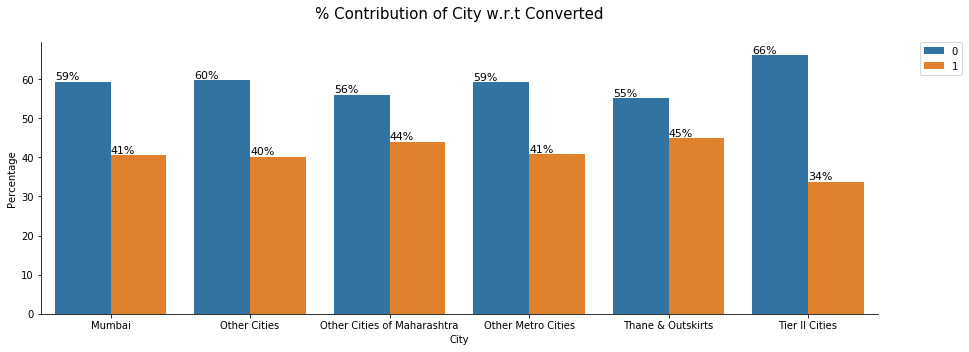

In [20]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'City','Converted',(15,5),15,11,0,1,0)

<font color='red'>

**‘City’ Column is not much useful, the lead conversion percentage within each item, more or less the same. and also missing values ~ 39%. So we can drop this feature. in addition to this most of the times 'Mumbai' selected**
</font>

In [21]:
# drop the column 'City'
df_leads.drop('City', axis =1, inplace = True)

In [22]:
# check the distribution of the categorical values.
df_leads['Specialization'].value_counts()

Finance Management                   976
Human Resource Management            848
Marketing Management                 838
Operations Management                503
Business Administration              403
IT Projects Management               366
Supply Chain Management              349
Banking, Investment And Insurance    338
Media and Advertising                203
Travel and Tourism                   203
International Business               178
Healthcare Management                159
Hospitality Management               114
E-COMMERCE                           112
Retail Management                    100
Rural and Agribusiness                73
E-Business                            57
Services Excellence                   40
Name: Specialization, dtype: int64

In [23]:
# check the null values in 'Specialization'
df_leads['Specialization'].isnull().sum()

3380

In [24]:
# Let’s replace null values with ‘Other_Specialization’ 
df_leads['Specialization'].replace(np.nan,'Other_Specialization', inplace = True)

<font color = 'red'>
    
**This column distribution of items is good and noted that missing values around 3400 data points. So let’s make imputation of missing values with ‘Other_Specialization’**
</font>

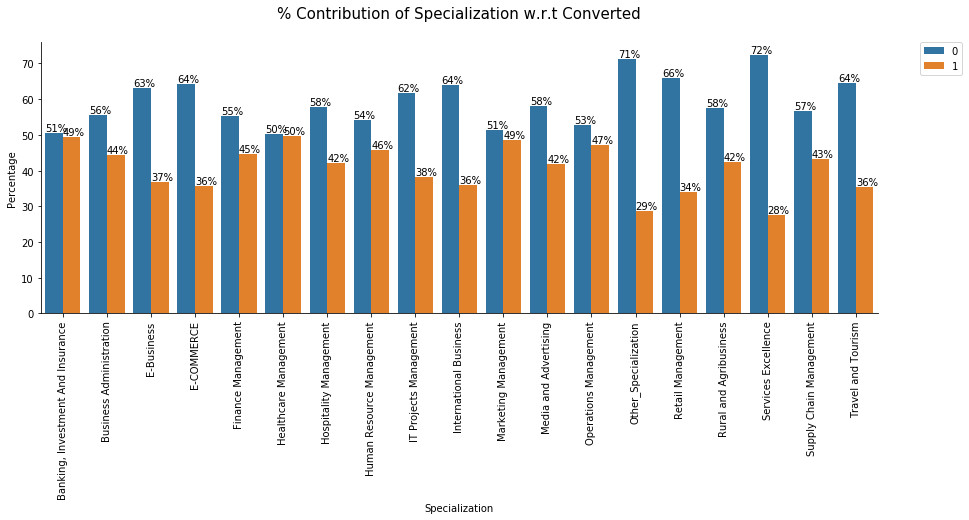

In [25]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'Specialization','Converted',(15,5),15,10,0,1,90)

In [26]:
# check the distribution of the categorical values.
df_leads['Specialization'].value_counts()

Other_Specialization                 3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Media and Advertising                 203
Travel and Tourism                    203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

<font color = 'red'>

**Let’s consider this column for now as this can be one of the feature related to bussines, if necessary then will recheck later.**
</font>

In [27]:
# check the distribution of the categorical values.
df_leads['Tags'].value_counts()

Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with EINS                                     12
Lost to Others

<font color = 'red'>

**Some unique items in this column are contributing  <10 data points, which can be grouped to one item as ‘Others’**
</font>

In [28]:
# create the list of all items which are having less than 10 count values
Tags_all_other_status_items = df_leads['Tags'].value_counts().index.tolist()[17:]

print('\033[1m'+'\x1b[31m'+'Unique items that are having less than 10 value counts: \n'+'\033[0m')
for i in Tags_all_other_status_items:
    print('\t'+'\033[94m'+ i)



Unique items that are having less than 10 value counts: 

	Lost to Others
	Still Thinking
	Want to take admission but has financial problems
	In confusion whether part time or DLP
	Interested in Next batch
	Lateral student
	University not recognized
	Shall take in the next coming month
	Recognition issue (DEC approval)


In [29]:
# check for the missing values
df_leads['Tags'].isnull().sum()

3353

In [30]:
# replace the list of items with ‘Others”
df_leads['Tags'] = df_leads['Tags'].apply(lambda X:'Others' if (X in Tags_all_other_status_items) else X)

In [31]:
# check the distribution of the categorical values.
df_leads['Tags'].value_counts()

Will revert after reading the email    2072
Ringing                                1203
Interested in other courses             513
Already a student                       465
Closed by Horizzon                      358
switched off                            240
Busy                                    186
Lost to EINS                            175
Not doing further education             145
Interested  in full time MBA            117
Graduation in progress                  111
invalid number                           83
Diploma holder (Not Eligible)            63
wrong number given                       47
Others                                   37
opp hangup                               33
number not provided                      27
in touch with EINS                       12
Name: Tags, dtype: int64

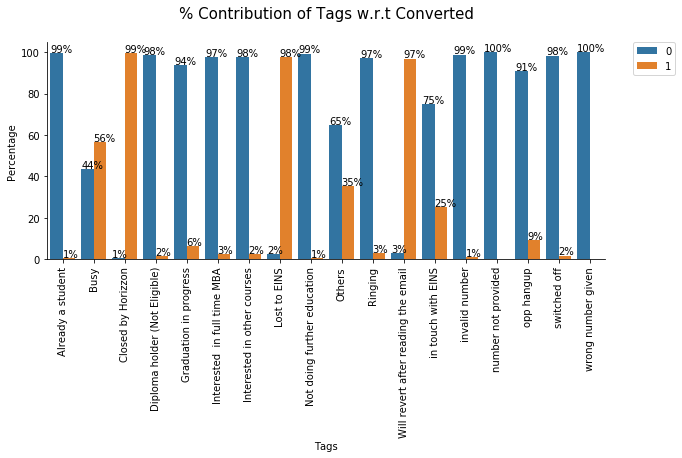

In [32]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'Tags','Converted',(10,4),15,10,0,1,90)

<font color='red'>

**This columns is an important feature to consider, as we can see that, “Will revert after reading the email” is the topmost frequent and around 97% of its value counts are lead converted.**

</font>

In [33]:
# check for missing values in 'Tags' columns
df_leads['Tags'].isnull().sum()

3353

In [34]:
# Let’s replace null values with ‘No_tags’, as we dont want to loose this many data points
df_leads['Tags'].replace(np.nan,'No_tags', inplace = True)

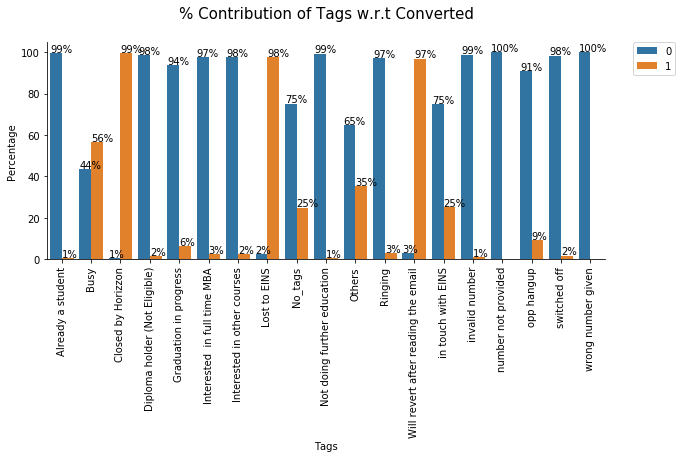

In [35]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'Tags','Converted',(10,4),15,10,0,1,90)

<font color = 'red'>

**We can consider this feature, as we can there is good clear information with "will revert after reading the email" tags most likely those leads will convert**

</font>

In [36]:
# check the distribution of the categorical values.
df_leads['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

<font color = 'red'>

**In this column, there is no variation in the data only one item selected most of the times, So not a good feature for modeling. We can drop this column.**

</font>

In [37]:
# drop the column 'What matters most to you in choosing a course'
df_leads.drop('What matters most to you in choosing a course', axis =1, inplace = True)

In [38]:
# check the distribution of the categorical values.
df_leads['What is your current occupation'].value_counts()

Unemployed              5600
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

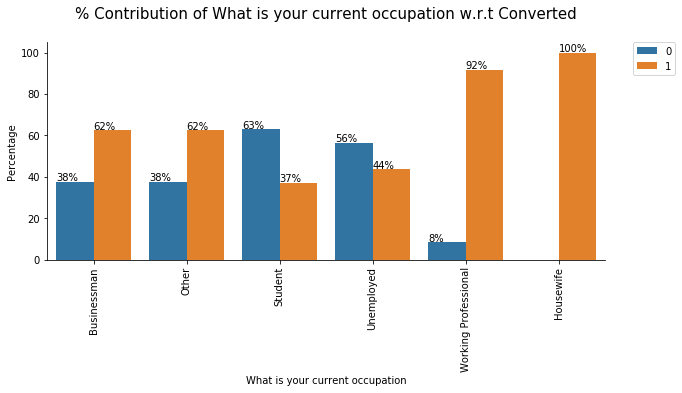

In [39]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'What is your current occupation','Converted',(10,4),15,10,0,1,90)

In [40]:
# check for missing values in 'What is your current occupation' columns
df_leads['What is your current occupation'].isnull().sum()

2690

<font color = 'red'>

**We can drop this column, as most of the time around 60% of the data points is ‘Unemployed’ and in addition to this around 30% missing values, So we can drop this column.**

</font>

In [41]:
# drop the column 'What is your current occupation'
df_leads.drop('What is your current occupation', axis =1, inplace = True)

In [42]:
# check the distribution of the categorical values.
df_leads['Country'].value_counts()

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
France                     6
Oman                       6
unknown                    5
South Africa               4
Canada                     4
Germany                    4
Kuwait                     4
Nigeria                    4
Sweden                     3
Netherlands                2
Uganda                     2
Italy                      2
China                      2
Asia/Pacific Region        2
Bangladesh                 2
Philippines                2
Belgium                    2
Ghana                      2
Tanzania                   1
Russia                     1
Indonesia                  1
Vietnam                    1
Malaysia                   1
Switzerland                1
Kenya         

<font color='red'>

**This column data highly skewed  to one item. If you check value_counts, around 6500 times India appear which is approximately 70% of data points. We can drop this column**

</font>

In [43]:
# drop the column 'Country'
df_leads.drop('Country', axis =1, inplace = True)

In [44]:
# check missing values in the data frame
df_leads.isnull().sum()

Prospect ID                                 0
Lead Number                                 0
Lead Origin                                 0
Lead Source                                36
Converted                                   0
TotalVisits                               137
Total Time Spent on Website                 0
Page Views Per Visit                      137
Last Activity                             103
Specialization                              0
Tags                                        0
A free copy of Mastering The Interview      0
Last Notable Activity                       0
dtype: int64

In [45]:
# shape of the data frame
df_leads.shape

(9240, 13)

In [46]:
# drop all missing value rows
df_leads.dropna(inplace = True)

In [47]:
# after missing value filter, shape of dataframe
df_leads.shape

(9074, 13)

In [48]:
# check the distribution of the categorical values.
df_leads['Lead Origin'].value_counts()

Landing Page Submission    4885
API                        3578
Lead Add Form               581
Lead Import                  30
Name: Lead Origin, dtype: int64

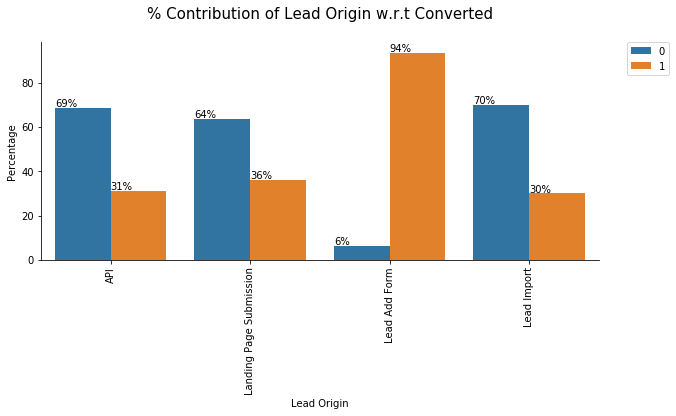

In [49]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'Lead Origin','Converted',(10,4),15,10,0,1,90)

In [50]:
# list the columns --> 'Lead Add Form' & 'Lead Import', since it is contributing very less part of data, we can drop those rows
Lead_Origin_add_form_items = df_leads['Lead Origin'].value_counts().index.tolist()[2:]
Lead_Origin_add_form_items

['Lead Add Form', 'Lead Import']

In [51]:
# impute np.nan in these two items 'Lead Add Form' & 'Lead Import', after that drop the rows 
df_leads['Lead Origin'] = df_leads['Lead Origin'].apply(lambda X:'Other' 
                                                        if (X in Lead_Origin_add_form_items) else X)

In [52]:
# drop the missing value (NaN) value rows
df_leads.dropna(inplace = True)

In [53]:
# shape of the data frame
df_leads.shape

(9074, 13)

In [54]:
# check the distribution of the categorical values.
df_leads['Lead Origin'].value_counts()

# Good feature to consider

Landing Page Submission    4885
API                        3578
Other                       611
Name: Lead Origin, dtype: int64

In [55]:
# check the distribution of the categorical values.
df_leads['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1753
Organic Search       1154
Reference             443
Welingak Website      129
Referral Sites        125
Facebook               31
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
NC_EDM                  1
Pay per Click Ads       1
blog                    1
welearnblog_Home        1
youtubechannel          1
testone                 1
WeLearn                 1
Name: Lead Source, dtype: int64

<font color = 'red'>

**Noticed duplicates with Google item name. So keep all items in lowercase to avoid these types of duplicates.**

</font>

In [56]:
# set all values to lowercase
df_leads['Lead Source'] = df_leads['Lead Source'].str.lower()

In [57]:
# check the distribution of the categorical values. and also there should not be any duplicates now
df_leads['Lead Source'].value_counts()

google               2873
direct traffic       2543
olark chat           1753
organic search       1154
reference             443
welingak website      129
referral sites        125
facebook               31
bing                    6
click2call              4
live chat               2
social media            2
press_release           2
nc_edm                  1
blog                    1
pay per click ads       1
welearnblog_home        1
testone                 1
welearn                 1
youtubechannel          1
Name: Lead Source, dtype: int64

In [58]:
# list all items, those value count <= 150
Lead_source_Other_items = df_leads['Lead Source'].value_counts().index.tolist()[5:]

print('\033[1m'+'\x1b[31m'+'list all items of the Category column, those value count <= 100: \n'+'\033[0m')
for i in Lead_source_Other_items:
    print('\t'+'\033[94m'+ i)

list all items of the Category column, those value count <= 100: 

	welingak website
	referral sites
	facebook
	bing
	click2call
	live chat
	social media
	press_release
	nc_edm
	blog
	pay per click ads
	welearnblog_home
	testone
	welearn
	youtubechannel


In [59]:
# impute np.nan in these items in the list, after that drop the rows
df_leads['Lead Source'] = df_leads['Lead Source'].apply(lambda X:np.nan if (X in Lead_source_Other_items) else X)

# check the distribution of the categorical values.
df_leads['Lead Source'].value_counts()

google            2873
direct traffic    2543
olark chat        1753
organic search    1154
reference          443
Name: Lead Source, dtype: int64

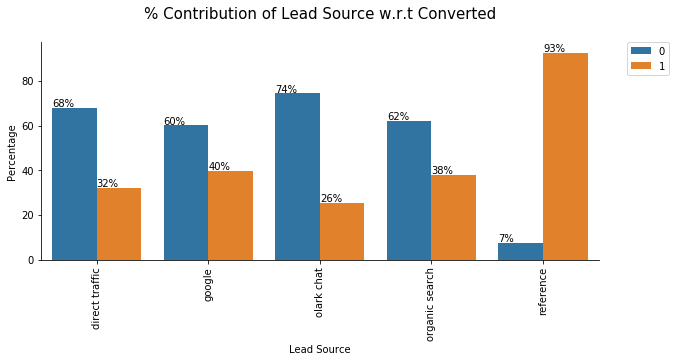

In [60]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'Lead Source','Converted',(10,4),15,10,0,1,90)

In [61]:
# drop missing rows
df_leads.dropna(inplace= True)

In [62]:
# shape of the data frame
df_leads.shape

(8766, 13)

In [63]:
# check the distribution of the categorical values.
df_leads['Last Activity'].value_counts()

Email Opened                    3300
SMS Sent                        2616
Olark Chat Conversation          954
Page Visited on Website          616
Converted to Lead                418
Email Bounced                    308
Email Link Clicked               257
Form Submitted on Website        114
Unreachable                       86
Unsubscribed                      56
Had a Phone Conversation          24
View in browser link Clicked       6
Approached upfront                 5
Email Received                     2
Email Marked Spam                  2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

In [64]:
# list all items, those value count <= 125
lst_Activity_Others_items = df_leads['Last Activity'].value_counts().index.tolist()[11:]

print('\033[1m'+'\x1b[31m'+'list all items of the Category column, those value count <= 100: \n'+'\033[0m')
for i in lst_Activity_Others_items:
    print('\t'+'\033[94m'+ i)

list all items of the Category column, those value count <= 100: 

	View in browser link Clicked
	Approached upfront
	Email Received
	Email Marked Spam
	Resubscribed to emails
	Visited Booth in Tradeshow


In [65]:
# impute np.nan in these items in the list, after that drop the rows
df_leads['Last Activity'] = df_leads['Last Activity'].apply(lambda X:np.nan if (X in lst_Activity_Others_items) else X)

# check the distribution of the categorical values.
df_leads['Last Activity'].value_counts()

Email Opened                 3300
SMS Sent                     2616
Olark Chat Conversation       954
Page Visited on Website       616
Converted to Lead             418
Email Bounced                 308
Email Link Clicked            257
Form Submitted on Website     114
Unreachable                    86
Unsubscribed                   56
Had a Phone Conversation       24
Name: Last Activity, dtype: int64

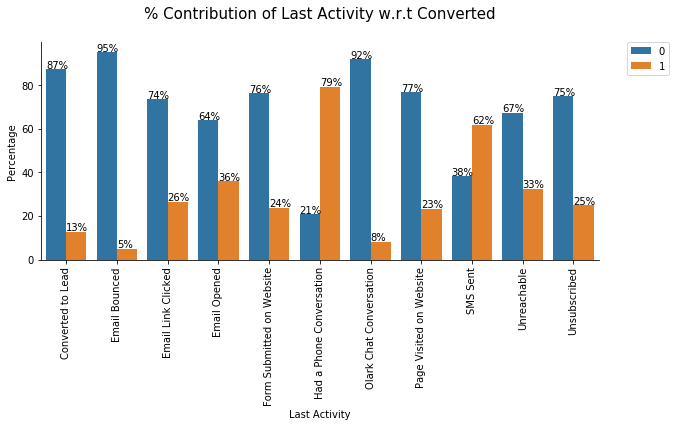

In [66]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'Last Activity','Converted',(10,4),15,10,0,1,90)

In [67]:
# drop the missing value rows
df_leads.dropna(inplace = True)

In [68]:
# shape of the data frame
df_leads.shape

(8749, 13)

In [69]:
# check the distribution of the categorical values.
df_leads['A free copy of Mastering The Interview'].value_counts()

No     5893
Yes    2856
Name: A free copy of Mastering The Interview, dtype: int64

In [70]:
# check the distribution of the categorical values.
df_leads['Last Notable Activity'].value_counts()

Modified                     3154
Email Opened                 2718
SMS Sent                     2078
Page Visited on Website       305
Olark Chat Conversation       181
Email Link Clicked            167
Email Bounced                  58
Unsubscribed                   42
Unreachable                    31
Had a Phone Conversation       14
Form Submitted on Website       1
Name: Last Notable Activity, dtype: int64

In [71]:
# list all items, those value count <= 300
Lst_note_Activity_Other_items = df_leads['Last Notable Activity'].value_counts().index.tolist()[6:]

print('\033[1m'+'\x1b[31m'+'list all items of the Category column, those value count <= 300: \n'+'\033[0m')
for i in Lst_note_Activity_Other_items:
    print('\t'+'\033[94m'+ i)


list all items of the Category column, those value count <= 300: 

	Email Bounced
	Unsubscribed
	Unreachable
	Had a Phone Conversation
	Form Submitted on Website


In [72]:
# impute np.nan in these items in the list, after that drop the rows
df_leads['Last Notable Activity'] = df_leads['Last Notable Activity'].apply(lambda X:np.nan 
                                                                            if (X in Lst_note_Activity_Other_items) else X)

# check the distribution of the categorical values.
df_leads['Last Notable Activity'].value_counts()

Modified                   3154
Email Opened               2718
SMS Sent                   2078
Page Visited on Website     305
Olark Chat Conversation     181
Email Link Clicked          167
Name: Last Notable Activity, dtype: int64

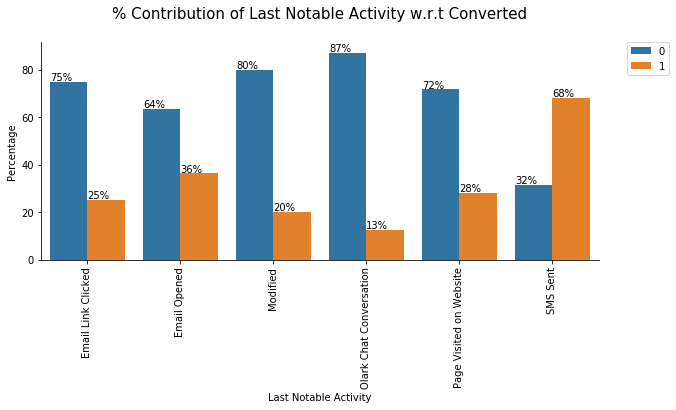

In [73]:
# barplot_wrt_hue(df,column_name,hue,figsize,titlefont,annot_size,En_OrderCat,Enlegend_shift,Xticks_rot)
barplot_wrt_hue(df_leads,'Last Notable Activity','Converted',(10,4),15,10,0,1,90)

In [74]:
# remove all missing rows from the data frame
df_leads.dropna(inplace = True)

In [75]:
# shape of the data frame
df_leads.shape

(8603, 13)

In [76]:
# check the unique values of each column
df_leads.apply(pd.Series.nunique)

Prospect ID                               8603
Lead Number                               8603
Lead Origin                                  3
Lead Source                                  5
Converted                                    2
TotalVisits                                 39
Total Time Spent on Website               1702
Page Views Per Visit                       111
Last Activity                               11
Specialization                              19
Tags                                        19
A free copy of Mastering The Interview       2
Last Notable Activity                        6
dtype: int64

<font color = 'red'>

**Note: ‘Prospect ID’ and ‘Lead Number’ both having all unique values. So keeping one out of these two will be ok. So we can drop ‘Prospect ID’**

</font>

In [77]:
# drop the listed columns 'list_of_drop_col'
df_leads.drop(columns = 'Prospect ID', inplace = True)

In [78]:
# set 'Lead Number' as index
df_leads.set_index('Lead Number', inplace= True)
df_leads.head()

,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,Tags,A free copy of Mastering The Interview,Last Notable Activity
Lead Number,,,,,,,,,,,
660737,API,olark chat,0,0.0,0,0.0,Page Visited on Website,Other_Specialization,Interested in other courses,No,Modified
660728,API,organic search,0,5.0,674,2.5,Email Opened,Other_Specialization,Ringing,No,Email Opened
660727,Landing Page Submission,direct traffic,1,2.0,1532,2.0,Email Opened,Business Administration,Will revert after reading the email,Yes,Email Opened
660719,Landing Page Submission,direct traffic,0,1.0,305,1.0,Unreachable,Media and Advertising,Ringing,No,Modified
660681,Landing Page Submission,google,1,2.0,1428,1.0,Converted to Lead,Other_Specialization,Will revert after reading the email,No,Modified


In [79]:
# shape of the data frame
df_leads.shape

(8603, 11)

<font color = 'red'>

**Outliers check for Numerical columns**

</font>

In [80]:
# Numerical columns list
Num_col_list = df_leads.select_dtypes(exclude = 'object').columns
Num_col_list

Index(['Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit'],
      dtype='object')

<font color = 'red'>

**We have 3 numerical variables to perform outliers treatment**

</font>

In [81]:
# check the numerical variables distribution
df_leads[Num_col_list].describe(percentiles = [0.25,0.5,0.75,0.90,0.95,0.99])

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,8603.000000,8603.000000,8603.000000,8603.000000
mean,0.371266,3.461234,489.101592,2.382080
std,0.483171,4.736903,546.836640,2.141436
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,16.500000,1.000000
50%,0.000000,3.000000,251.000000,2.000000
75%,1.000000,5.000000,938.000000,3.200000
90%,1.000000,7.000000,1378.000000,5.000000
95%,1.000000,10.000000,1558.000000,6.000000
99%,1.000000,17.000000,1838.960000,9.000000


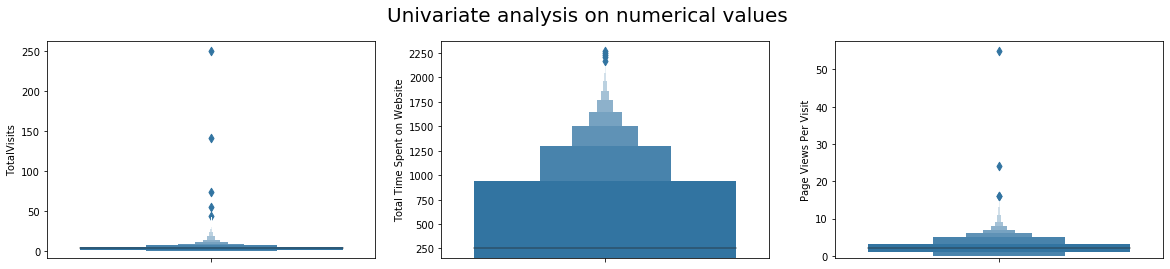

In [82]:
# plot the boxenplots to check the numerical distribution 
fig = plt.figure(figsize=(20, 4)) 

plt.subplot(131)
sns.boxenplot(y = 'TotalVisits', data = df_leads)

plt.subplot(132)
sns.boxenplot(y = 'Total Time Spent on Website', data = df_leads)

plt.subplot(133)
sns.boxenplot(y = 'Page Views Per Visit', data = df_leads)

fig.suptitle('Univariate analysis on numerical values',fontsize=20,x =0.5, y=1)
plt.show()

<font color = 'red'>
    
**Total Visits & Page Views per visit having outliers, let’s perform outliers treatment.**

</font>

In [83]:
#defined function for filter outliers -- # removing (statistical) outliers
def filter_OutLiers(df,column_name):
    Q1 = df[column_name].quantile(0.05)
    Q3 = df[column_name].quantile(0.95)
    IQR = Q3 - Q1
    df_temp = df.loc[((df[column_name] >= (Q1 - 1.5 * IQR)) & (df[column_name] <= (Q3 + 1.5 * IQR)))]
    return(df_temp)

In [84]:
# Outliers treatment on df_leads numerical variables
for i in Num_col_list[1:]:
    df_leads = filter_OutLiers(df_leads,i).copy()
df_leads.shape

(8580, 11)

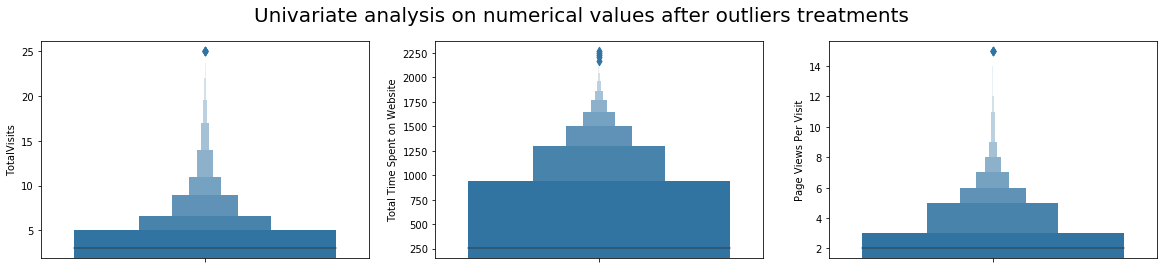

In [85]:
# plot the boxenplots to check the numerical distribution after outliers treatments 
fig = plt.figure(figsize=(20, 4)) 

plt.subplot(131)
sns.boxenplot(y = 'TotalVisits', data = df_leads)

plt.subplot(132)
sns.boxenplot(y = 'Total Time Spent on Website', data = df_leads)

plt.subplot(133)
sns.boxenplot(y = 'Page Views Per Visit', data = df_leads)

fig.suptitle('Univariate analysis on numerical values after outliers treatments',fontsize=20,x =0.5, y=1)
plt.show()

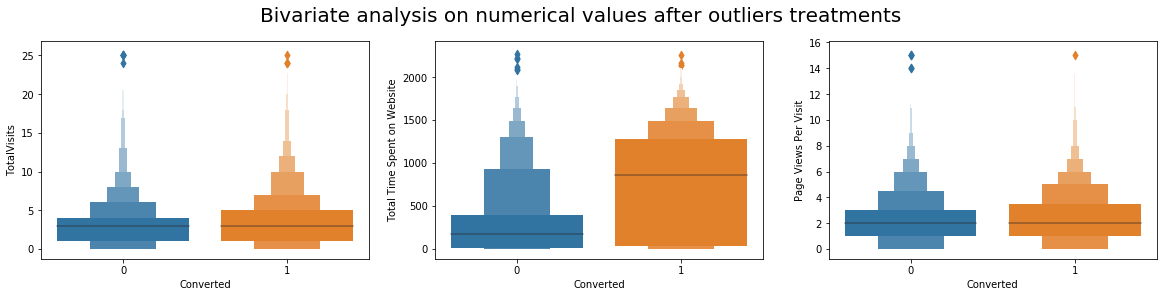

In [86]:
# plot the boxenplots to check the numerical distribution after outliers treatments 
fig = plt.figure(figsize=(20, 4)) 

plt.subplot(131)
sns.boxenplot(y = 'TotalVisits',x = 'Converted', data = df_leads)

plt.subplot(132)
sns.boxenplot(y = 'Total Time Spent on Website', x = 'Converted',data = df_leads)

plt.subplot(133)
sns.boxenplot(y = 'Page Views Per Visit', x = 'Converted', data = df_leads)

fig.suptitle('Bivariate analysis on numerical values after outliers treatments',fontsize=20,x =0.5, y=1)
plt.show()

<font color= 'red'>

**Total Time Spent on Website, looks more relevant to consider. But any have let's consider all 3 numerical variable for modeling. If something not ok , then we will eliminate the remaining 2 (Total Visits & Page Views Per Visit) variables.**

</font>

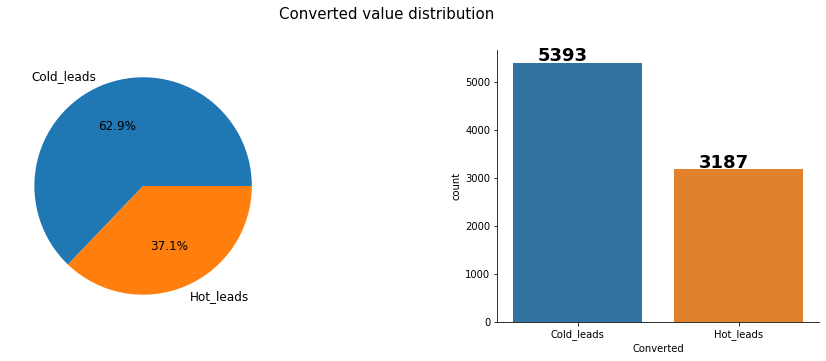

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
fig.suptitle('Converted value distribution',fontsize=15, y=1.0)
ax = axes[0]
ax.pie(df_leads['Converted'].value_counts(), labels= ['Cold_leads', 'Hot_leads'], 
       autopct = '%1.1f%%',textprops={'size': 'large'}) 

fig1 = sns.countplot(x = 'Converted', data = df_leads)
plt.xticks([0,1],labels = ['Cold_leads', 'Hot_leads'])
sns.despine(top=True, right=True, left=False, bottom=False)
for p in fig1.patches:
    
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    fig1.annotate('{:.0f}'.format(height), (x+0.15, y + height*1.01),fontsize=18,weight='bold')
fig.subplots_adjust(wspace=0.6)
plt.show()

<font color = 'red'>

**Target variable distribution:  
`Cold leads` are about `62.9%` & `Hot leads` are about `37.1%`.**
</font>

<font color = 'blue'>

# Data Preparation

</font>

In [88]:
# list of data frame columns  
df_leads.columns

Index(['Lead Origin', 'Lead Source', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'Tags', 'A free copy of Mastering The Interview',
       'Last Notable Activity'],
      dtype='object')

In [89]:
# Numerical columns list
Num_col_list = df_leads.select_dtypes(exclude = 'object').columns

print('\033[1m'+'\x1b[31m'+'Numerical columns list including Target variable: \n'+'\033[0m')
for i in Num_col_list:
    print('\t'+'\033[94m'+ i)


Numerical columns list including Target variable: 

	Converted
	TotalVisits
	Total Time Spent on Website
	Page Views Per Visit


In [90]:
# Categorical columns list
Cat_col_list = df_leads.select_dtypes(include = 'object').columns

print('\033[1m'+'\x1b[31m'+'Categorical variables list: \n'+'\033[0m')
for i in Cat_col_list:
    print('\t'+'\033[94m'+ i)


Categorical variables list: 

	Lead Origin
	Lead Source
	Last Activity
	Specialization
	Tags
	A free copy of Mastering The Interview
	Last Notable Activity


In [91]:
# before creating dummy variables, add column name to its respective items,
#so that it will be easy to understand variable after creating dummies

for i in Cat_col_list:
    df_leads[i] = df_leads[i].apply(lambda X : i+'_'+X)

In [92]:
# check the first row to ensure all categories having prefix_names
df_leads.head(1)

,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,Tags,A free copy of Mastering The Interview,Last Notable Activity
Lead Number,,,,,,,,,,,
660737,Lead Origin_API,Lead Source_olark chat,0,0.0,0,0.0,Last Activity_Page Visited on Website,Specialization_Other_Specialization,Tags_Interested in other courses,A free copy of Mastering The Interview_No,Last Notable Activity_Modified


In [93]:
# Create dummy variables for all category variables
for i in Cat_col_list:
    temp_df = pd.get_dummies(df_leads[i], drop_first = True)
    df_leads = pd.concat([df_leads,temp_df], axis =1)  

In [94]:
# Delete all original categorical variables
df_leads.drop(columns = Cat_col_list, inplace = True)

In [95]:
# shape of the data frame
df_leads.shape

(8580, 62)

In [96]:
# keep the dataframe values in float type
df_leads = df_leads.astype('float64')
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8580 entries, 660737 to 579533
Data columns (total 62 columns):
Converted                                        8580 non-null float64
TotalVisits                                      8580 non-null float64
Total Time Spent on Website                      8580 non-null float64
Page Views Per Visit                             8580 non-null float64
Lead Origin_Landing Page Submission              8580 non-null float64
Lead Origin_Other                                8580 non-null float64
Lead Source_google                               8580 non-null float64
Lead Source_olark chat                           8580 non-null float64
Lead Source_organic search                       8580 non-null float64
Lead Source_reference                            8580 non-null float64
Last Activity_Email Bounced                      8580 non-null float64
Last Activity_Email Link Clicked                 8580 non-null float64
Last Activity_Email Opened        

In [97]:
# split train _ Test data sets
df_leads_train, df_leads_test = train_test_split(df_leads, train_size = 0.7, test_size = 0.3, random_state = 42)

In [98]:
# Train and test data frames shapes
print('train dataset shape :',df_leads_train.shape)
print('test dataset shape :',df_leads_test.shape)

train dataset shape : (6006, 62)
test dataset shape : (2574, 62)


<font color = 'blue'>

## Apply Standard scaler on train set numerical variables

</font>

In [99]:
# apply scaler() to the numerical variables, "Num_col_list" --> list of numerical variables before dummy variables
df_leads_train[Num_col_list[1:]] = scaler.fit_transform(df_leads_train[Num_col_list[1:]])
df_leads_train.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Other,Lead Source_google,Lead Source_olark chat,Lead Source_organic search,Lead Source_reference,...,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,A free copy of Mastering The Interview_Yes,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent
Lead Number,,,,,,,,,,,,,,,,,,,,,
608403,0.0,1.100708,-0.509261,2.244882,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
631831,0.0,0.496038,0.909474,1.272742,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
606730,0.0,-1.015635,-0.901328,-1.157607,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
645791,0.0,-0.410966,-0.844798,-0.185467,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
653072,0.0,0.193704,-0.842974,0.786672,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [100]:
df_leads_train.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Other,Lead Source_google,Lead Source_olark chat,Lead Source_organic search,Lead Source_reference,...,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,A free copy of Mastering The Interview_Yes,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent
count,6006.000000,6.006000e+03,6.006000e+03,6.006000e+03,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,...,6006.000000,6006.00000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000
mean,0.371628,-1.200061e-16,-2.203440e-16,-2.925103e-16,0.548951,0.049451,0.329337,0.202131,0.129870,0.049284,...,0.001998,0.00383,0.028472,0.005495,0.324675,0.321845,0.367133,0.022145,0.033300,0.236763
std,0.483280,1.000083e+00,1.000083e+00,1.000083e+00,0.497639,0.216825,0.470012,0.401623,0.336188,0.216478,...,0.044658,0.06177,0.166330,0.073927,0.468292,0.467223,0.482063,0.147166,0.179434,0.425131
min,0.000000,-1.015635e+00,-9.013283e-01,-1.157607e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.133007e-01,-8.698718e-01,-6.715370e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.086311e-01,-4.326715e-01,-1.854673e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.960385e-01,8.255898e-01,4.512841e-01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,6.542734e+00,3.207169e+00,6.133440e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [101]:
# Dividing train dataset into X and Y sets for the model building
y_train = df_leads_train.pop('Converted')
X_train = df_leads_train

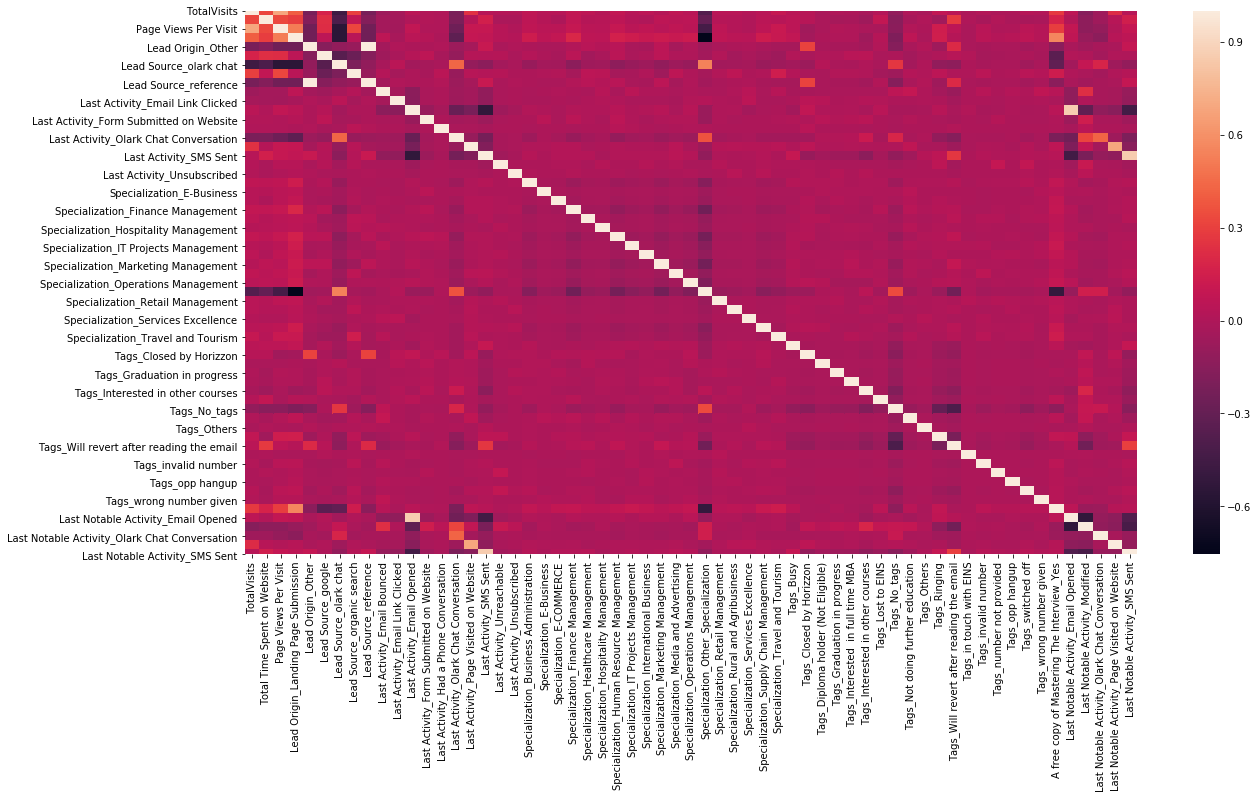

In [102]:
# correlation plot between features
plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr())
plt.show()

<font color = 'blue'>

# Model Building

</font>

In [103]:
# Initial model building
lg = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
lg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6006
Model:                            GLM   Df Residuals:                     5944
Model Family:                Binomial   Df Model:                           61
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1135.3
Date:                Sat, 25 Jan 2020   Deviance:                       2270.6
Time:                        19:55:08   Pearson chi2:                 1.10e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -6.8114      1.167     -5.837      0.000      -9.099      -4.524
TotalVisits                                       0.1996      0.078      2.551      0.011       0.046       0.353
Total Time Spent on Website                       1.0930      0.065     16.798      0.000       0.965       1.221
Page Views Per Visit                             -0.2186      0.091     -2.412      0.016      -0.396      -0.041
Lead Origin_Landing Page Submission              -0.6818      0.240     -2.847      0.004      -1.151      -0.212
Lead Origin_Other                                23.6973   2.16e+05      0.000      1.000   -4.23e+05    4.23e+05
Lead Source_google                               -0.0637      0.192     -0.332      0.740      -0.440       0.313
Lead Source_olark chat                            0.8301      0.250      3.317      0.001       0.340       1.321
Lead Source_organic search                        0.0112      0.221      0.051      0.959      -0.422       0.445
Lead Source_reference                           -22.5127   2.16e+05     -0.000      1.000   -4.23e+05    4.23e+05
Last Activity_Email Bounced                      -1.0005      0.734     -1.364      0.173      -2.438       0.437
Last Activity_Email Link Clicked                  1.2071      0.696      1.734      0.083      -0.157       2.572
Last Activity_Email Opened                        0.6501      0.457      1.423      0.155      -0.245       1.546
Last Activity_Form Submitted on Website           1.2206      0.667      1.830      0.067      -0.087       2.528
Last Activity_Had a Phone Conversation            1.1088      1.536      0.722      0.470      -1.901       4.119
Last Activity_Olark Chat Conversation            -0.2576      0.471     -0.547      0.585      -1.181       0.666
Last Activity_Page Visited on Website             0.6542      0.516      1.268      0.205      -0.357       1.666
Last Activity_SMS Sent                            1.7871      0.425      4.210      0.000       0.955       2.619
Last Activity_Unreachable                         0.1989      1.300      0.153      0.878      -2.349       2.746
Last Activity_Unsubscribed                       -1.3880      2.731     -0.508      0.611      -6.740       3.964
Specialization_Business Administration            0.4437      0.399      1.111      0.266      -0.339       1.226
Specialization_E-Business                        -0.6757      0.719     -0.940      0.347      -2.085       0.733
Specialization_E-COMMERCE                         0.6752      0.549      1.229      0.219      -0.402       1.752
Specialization_Finance Management                 0.2441      0.349      0.700      0.484      -0.440       0.928
Speci

<font color = 'red'>

**There are a lot of features, that are not significant. Let use RFE for feature selection.**

</font>

<font color = 'blue'>

**Feature Selection using RFE**

</font>

In [104]:
lm = LinearRegression() # creating linear regression object
lm.fit(X_train, y_train)

# set RFE with 15 features

rfe = RFE(lm, 15) # running RFE
rfe = rfe.fit(X_train, y_train)

In [105]:
# result 15 columns from RFE
rfe_col = X_train.columns[rfe.support_]
rfe_col

Index(['Total Time Spent on Website', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Other', 'Lead Source_reference',
       'Last Activity_Olark Chat Conversation', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_No_tags',
       'Tags_Others', 'Tags_Will revert after reading the email',
       'Tags_in touch with EINS', 'Tags_number not provided',
       'Tags_wrong number given', 'Last Notable Activity_SMS Sent'],
      dtype='object')

In [106]:
# check the correlation values of RFE selected variables with respect to target variable
pd.concat([df_leads_train[rfe_col], y_train], axis = 1).corr()['Converted'].sort_values(ascending=False)

Converted                                   1.000000
Tags_Will revert after reading the email    0.661676
Total Time Spent on Website                 0.386770
Last Notable Activity_SMS Sent              0.348156
Lead Origin_Other                           0.263214
Lead Source_reference                       0.262635
Tags_Closed by Horizzon                     0.240048
Tags_Lost to EINS                           0.175806
Tags_Busy                                   0.055716
Tags_in touch with EINS                     0.000255
Tags_Others                                -0.000175
Lead Origin_Landing Page Submission        -0.020952
Tags_number not provided                   -0.034410
Tags_wrong number given                    -0.057162
Last Activity_Olark Chat Conversation      -0.215595
Tags_No_tags                               -0.227908
Name: Converted, dtype: float64

<font color = 'blue'>

## Model_1

</font>

In [107]:
# Creating X_train dataset with RFE selected variables
X_train_rfe = X_train[rfe_col]

In [108]:
# Model with rfe selected feature
X_train_sm = sm.add_constant(X_train_rfe)

lg_rfe = sm.GLM(y_train,(X_train_sm), family = sm.families.Binomial()).fit()

lg_rfe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6006
Model:                            GLM   Df Residuals:                     5990
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1225.6
Date:                Sat, 25 Jan 2020   Deviance:                       2451.1
Time:                        19:55:08   Pearson chi2:                 7.35e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -4.0035      0.182    -21.955      0.000      -4.361      -3.646
Total Time Spent on Website                  0.9505      0.056     17.084      0.000       0.841       1.060
Lead Origin_Landing Page Submission         -1.0568      0.119     -8.848      0.000      -1.291      -0.823
Lead Origin_Other                           22.0894   1.31e+05      0.000      1.000   -2.57e+05    2.57e+05
Lead Source_reference                      -21.0895   1.31e+05     -0.000      1.000   -2.57e+05    2.57e+05
Last Activity_Olark Chat Conversation       -1.4613      0.236     -6.194      0.000      -1.924      -0.999
Tags_Busy                                    3.6201      0.265     13.666      0.000       3.101       4.139
Tags_Closed by Horizzon                      9.6748      1.025      9.443      0.000       7.667      11.683
Tags_Lost to EINS                            8.2690      0.623     13.264      0.000       7.047       9.491
Tags_No_tags                                 2.8627      0.171     16.696      0.000       2.527       3.199
Tags_Others                                  3.1024      0.559      5.555      0.000       2.008       4.197
Tags_Will revert after reading the email     7.3368      0.238     30.798      0.000       6.870       7.804
Tags_in touch with EINS                      3.4928      0.978      3.571      0.000       1.576       5.410
Tags_number not provided                   -21.7843   3.35e+04     -0.001      0.999   -6.58e+04    6.57e+04
Tags_wrong number given                    -20.9717   2.06e+04     -0.001      0.999   -4.04e+04    4.04e+04
Last Notable Activity_SMS Sent               2.3902      0.128     18.648      0.000       2.139       2.641
============================================================================================================
"""

<font color = 'red'>

**Model Summary with RFE selected features, 4 features are  less significant ( p value >0.05). So we do drop one of the variables in this case 'Lead Origin_Other' and proceed for another model to check again new model p-values**

</font>

<font color = 'blue'>

## Model_2
</font>

In [109]:
# 'Lead Origin_Other' p-value is more than 0.05, we can drop this feature 
X_train_rfe_new = X_train_rfe.drop('Lead Origin_Other', axis= 1)

X_train_sm = sm.add_constant(X_train_rfe_new)

lg_rfe_2 = sm.GLM(y_train,(X_train_sm), family = sm.families.Binomial()).fit()
lg_rfe_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6006
Model:                            GLM   Df Residuals:                     5991
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1225.6
Date:                Sat, 25 Jan 2020   Deviance:                       2451.3
Time:                        19:55:08   Pearson chi2:                 7.36e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -4.0029      0.182    -21.954      0.000      -4.360      -3.646
Total Time Spent on Website                  0.9504      0.056     17.081      0.000       0.841       1.059
Lead Origin_Landing Page Submission         -1.0575      0.119     -8.854      0.000      -1.292      -0.823
Lead Source_reference                        0.9985      0.434      2.298      0.022       0.147       1.850
Last Activity_Olark Chat Conversation       -1.4620      0.236     -6.196      0.000      -1.924      -1.000
Tags_Busy                                    3.6201      0.265     13.666      0.000       3.101       4.139
Tags_Closed by Horizzon                      9.6751      1.025      9.443      0.000       7.667      11.683
Tags_Lost to EINS                            8.2691      0.623     13.264      0.000       7.047       9.491
Tags_No_tags                                 2.8625      0.171     16.695      0.000       2.526       3.199
Tags_Others                                  3.1024      0.558      5.555      0.000       2.008       4.197
Tags_Will revert after reading the email     7.3390      0.238     30.808      0.000       6.872       7.806
Tags_in touch with EINS                      3.4924      0.978      3.571      0.000       1.576       5.409
Tags_number not provided                   -21.7841   3.35e+04     -0.001      0.999   -6.58e+04    6.57e+04
Tags_wrong number given                    -20.9717   2.06e+04     -0.001      0.999   -4.04e+04    4.04e+04
Last Notable Activity_SMS Sent               2.3902      0.128     18.647      0.000       2.139       2.641
============================================================================================================
"""

<font color = 'blue'>

## Model_3
</font>

In [110]:
# 'Tags_number not provided' p-value is more than 0.05, we can drop this feature 
X_train_rfe_new = X_train_rfe_new.drop('Tags_number not provided', axis= 1)

X_train_sm = sm.add_constant(X_train_rfe_new)

lg_rfe_3 = sm.GLM(y_train,(X_train_sm), family = sm.families.Binomial()).fit()
lg_rfe_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6006
Model:                            GLM   Df Residuals:                     5992
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1226.4
Date:                Sat, 25 Jan 2020   Deviance:                       2452.9
Time:                        19:55:08   Pearson chi2:                 7.40e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -4.0161      0.182    -22.007      0.000      -4.374      -3.658
Total Time Spent on Website                  0.9491      0.056     17.071      0.000       0.840       1.058
Lead Origin_Landing Page Submission         -1.0584      0.119     -8.861      0.000      -1.293      -0.824
Lead Source_reference                        1.0017      0.435      2.301      0.021       0.149       1.855
Last Activity_Olark Chat Conversation       -1.4628      0.236     -6.200      0.000      -1.925      -1.000
Tags_Busy                                    3.6357      0.265     13.728      0.000       3.117       4.155
Tags_Closed by Horizzon                      9.6881      1.025      9.456      0.000       7.680      11.696
Tags_Lost to EINS                            8.2829      0.623     13.285      0.000       7.061       9.505
Tags_No_tags                                 2.8769      0.172     16.771      0.000       2.541       3.213
Tags_Others                                  3.1167      0.558      5.582      0.000       2.022       4.211
Tags_Will revert after reading the email     7.3528      0.238     30.857      0.000       6.886       7.820
Tags_in touch with EINS                      3.5061      0.978      3.586      0.000       1.590       5.422
Tags_wrong number given                    -19.9558   1.25e+04     -0.002      0.999   -2.45e+04    2.45e+04
Last Notable Activity_SMS Sent               2.3877      0.128     18.632      0.000       2.137       2.639
============================================================================================================
"""

<font color = 'red'>
    
**let’s check VIF values to ensure there is no multicollinearity.**
</font>

In [111]:
# Calculate VIF 
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

NameError: name 'variance_inflation_factor' is not defined

<font color = 'blue'>

## Model_4

</font>

In [ ]:
#‘Tags_wrong number given’ is having a VIF value of more than 5. So we can drop this feature to avoid multicollinearity.
X_train_rfe_new = X_train_rfe_new.drop('Tags_wrong number given', axis= 1)

X_train_sm = sm.add_constant(X_train_rfe_new)

lg_rfe_4 = sm.GLM(y_train,(X_train_sm), family = sm.families.Binomial()).fit()
lg_rfe_4.summary()

In [ ]:
# Calculate VIF 
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

<font color = 'red'>

**All features are significant and also there is no multicollinearity issue with Model_4.**

</font>

<font color = 'blue'>

## Prediction on train set

</font>

In [ ]:
# Getting the predicted values on the train set
y_train_pred = lg_rfe_4.predict(X_train_sm).values.reshape(-1)
y_train_pred[:10]

In [ ]:
# create a data frame with target variable and probabilities
y_train_pred_prob = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_prob['Lead Number'] = y_train.index
y_train_pred_prob.head()

In [ ]:
# create new columns 'Converted_pred' by using 'Converted_Prob' values. 1 if Coverted_Prob > 0.5 else 0
y_train_pred_prob['Converted_pred'] = y_train_pred_prob.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_prob.head()

In [ ]:
# Check the distribution of probability, should be with in 0-1
y_train_pred_prob['Converted_Prob'].describe()

In [ ]:
# this function plot the confusion matrix
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_prob.Converted, y_train_pred_prob.Converted_pred )
print(confusion)

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(confusion, classes=['Converted = 0','Converted = 1'],normalize= False,  title='Confusion matrix')

In [ ]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_prob.Converted, y_train_pred_prob.Converted_pred).round(2))

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Let's see the sensitivity of our logistic regression model
(TP / float(TP+FN)).round(2)

In [ ]:
# Let us calculate specificity
(TN / float(TN+FP)).round(2)

In [ ]:
# Calculate false postive rate - predicting churn when customer does not have churned
print((FP/ float(TN+FP)).round(2))

In [ ]:
# positive predictive value 
print ((TP / float(TP+FP)).round(2))

<font color = 'blue'>

## Ploting ROC curve

</font>

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [ ]:
# Draw ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_prob.Converted, y_train_pred_prob.Converted_pred)

draw_roc(y_train_pred_prob.Converted, y_train_pred_prob.Converted_pred)

<font color = 'blue'>

## Finding optimal cutoff point

</font>

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_prob[i]= y_train_pred_prob.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_prob.head()

In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_prob.Converted, y_train_pred_prob[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
# from the above plot, choose cutoff 0.27 to make 
y_train_pred_prob['final_predicted'] = y_train_pred_prob.Converted_Prob.map( lambda x: 1 if x > 0.27 else 0)

y_train_pred_prob.head()

In [ ]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_prob.Converted, y_train_pred_prob.final_predicted).round(2)

In [ ]:
# create confusion matrix
confusion_final = metrics.confusion_matrix(y_train_pred_prob.Converted, y_train_pred_prob.final_predicted)
confusion_final

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(confusion_final, classes=['Converted = 0','Converted = 1'],normalize= False,  title='Confusion matrix')

In [ ]:
TP = confusion_final[1,1] # true positive 
TN = confusion_final[0,0] # true negatives
FP = confusion_final[0,1] # false positives
FN = confusion_final[1,0] # false negatives

In [ ]:
# Let's see the sensitivity of our logistic regression model
(TP / float(TP+FN)).round(2)

In [ ]:
# Let us calculate specificity
(TN / float(TN+FP)).round(2)

In [ ]:
# Calculate false postive rate - predicting Converted when the lead did not Converted
print((FP/ float(TN+FP)).round(2))

In [ ]:
# Positive predictive value 
print ((TP / float(TP+FP)).round(2))

In [ ]:
# Negative predictive value
print ((TN / float(TN+ FN)).round(2))

<font color = 'blue'>

## Precision and recall tradeoff

</font>

In [ ]:
# precision score
precision_score(y_train_pred_prob.Converted, y_train_pred_prob.Converted_pred).round(2)

In [ ]:
# recall score
recall_score(y_train_pred_prob.Converted, y_train_pred_prob.Converted_pred).round(2)

In [ ]:
# plot the precision recall curve
p, r, thresholds = precision_recall_curve(y_train_pred_prob.Converted, y_train_pred_prob.Converted_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.vlines(x=0.37, ymax=1, ymin=-0, colors="r", linestyles="--")
plt.show()

<font color = 'blue'>

## Considering Precision and recall trade off values, let’s check train set results with 0.37.

</font>

In [ ]:
# from the above plot, choose cutoff 0.37 to make 
y_train_pred_prob['final_predicted'] = y_train_pred_prob.Converted_Prob.map( lambda x: 1 if x > 0.37 else 0)

y_train_pred_prob.head()

In [ ]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_prob.Converted, y_train_pred_prob.final_predicted).round(2)

In [ ]:
# create confusion matrix
confusion_final = metrics.confusion_matrix(y_train_pred_prob.Converted, y_train_pred_prob.final_predicted)
confusion_final

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(confusion_final, classes=['Converted = 0','Converted = 1'],normalize= False,  title='Confusion matrix')

In [ ]:
TP = confusion_final[1,1] # true positive 
TN = confusion_final[0,0] # true negatives
FP = confusion_final[0,1] # false positives
FN = confusion_final[1,0] # false negatives

In [ ]:
# Let's see the sensitivity of our logistic regression model
(TP / float(TP+FN)).round(2)

In [ ]:
# Let us calculate specificity
(TN / float(TN+FP)).round(2)

In [ ]:
# Calculate false postive rate - predicting Converted when the lead did not Converted
print((FP/ float(TN+FP)).round(2))

In [ ]:
# Positive predictive value 
print ((TP / float(TP+FP)).round(2))

In [ ]:
# Negative predictive value
print ((TN / float(TN+ FN)).round(2))

<font color = 'blue'>

## prediction on test set

</font>

In [ ]:
df_leads_test.head()

In [ ]:
Num_col_list

In [ ]:
# check the numerical columns in test set
df_leads_test[Num_col_list].columns

In [ ]:
# apply scaler() to the numerical variables, "Num_col_list" --> list of numerical variables before dummy variables
df_leads_test[Num_col_list[1:]] = scaler.transform(df_leads_test[Num_col_list[1:]])
df_leads_test.head()

In [ ]:
# Dividing train dataset into X and Y sets for the model building
y_test = df_leads_test.pop('Converted')
X_test = df_leads_test

In [ ]:
# final model_4 columns list
X_train_rfe_new.columns

In [ ]:
# Creating X_test dataset with RFE selected variables
X_test_rfe = X_test[X_train_rfe_new.columns]

In [ ]:
# predict probabilities
X_test_sm = sm.add_constant(X_test_rfe)

y_test_pred = lg_rfe_4.predict(X_test_sm)
y_test_pred.head()

In [ ]:
# create a data frame with target variable and probabilities
y_test_pred_prob = pd.DataFrame({'Converted':y_test.values, 'Converted_Prob':y_test_pred})
y_test_pred_prob['Lead Number'] = y_test.index
y_test_pred_prob.head()

In [ ]:
# create new columns 'final_predicted' by using 'Converted_Prob' values. 1 if Coverted_Prob > 0.37 else 0
y_test_pred_prob['final_predicted'] = y_test_pred_prob.Converted_Prob.map( lambda x: 1 if x > 0.37 else 0)

y_test_pred_prob.head()

In [ ]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred_prob.Converted, y_test_pred_prob.final_predicted).round(2)

In [ ]:
# create confusion matrix
confusion_test = metrics.confusion_matrix(y_test_pred_prob.Converted, y_test_pred_prob.final_predicted)
confusion_test

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(confusion_test, classes=['Converted = 0','Converted = 1'],normalize= False,  title='Confusion matrix')

In [ ]:
TP = confusion_test[1,1] # true positive 
TN = confusion_test[0,0] # true negatives
FP = confusion_test[0,1] # false positives
FN = confusion_test[1,0] # false negatives

In [ ]:
# Let's see the sensitivity of our logistic regression model on test data set
(TP / float(TP+FN)).round(2)

In [ ]:
# Let us calculate specificity
(TN / float(TN+FP)).round(2)

In [ ]:
# Calculate false postive rate - predicting Converted when the lead did not Converted
print((FP/ float(TN+FP)).round(2))

In [ ]:
# Positive predictive value 
print((TP / float(TP+FP)).round(2))

In [ ]:
# Negative predictive value
print ((TN / float(TN+ FN)).round(2))

<font color = 'blue'>

### Final Model Results:
</font>

| <font color ='blue'>Dataset</font> | <font color ='blue'>Accuracy</font> | <font color ='blue'>Sensitivity</font> | <font color ='blue'>Specificity</font> | False postive rate | Postive predictive rate | Negative prediction rate|
| --- | --- | --- | --- | --- | --- | --- |
| <font color ='red'>Train</font> |<font color ='blue'> 89%</font> |<font color ='blue'> 88%</font> |<font color ='blue'> 91%</font> | 9% | 83% | 93% |
| <font color ='red'>Test</font> |<font color ='blue'> 89%</font> |<font color ='blue'> 85%</font> |<font color ='blue'> 92%</font> | 8% | 85% | 92% |



In [ ]:
# Create data frame with final model features along with their weights as a values.
df_final_model_features = lg_rfe_4.params.sort_values(ascending = False)
df_final_model_features.drop(index = 'const', inplace = True)
df_final_model_features

In [ ]:
# plot the final model features with its weights
sns.barplot(x = df_final_model_features.values, y = df_final_model_features.index)
plt.title('Plot the final model features with its weights')
plt.show()